# Sentiment Analysis of Tweets by Brand <a class="anchor" id="Top"></a>
#### Authors: Eddie Prado, Sally Heinzel, Valeria Viscarra Fossati, and Weston Shuken

![Header Image](/images/sentiment_analysis_header.png)

###### Image by SurveySensum

## Table of Contents
* [Overview](#Overview)
* [Business Opportunity](#Business_Opportunity)
* [Data & Methods](#Data_Methods)
* [Data Exploration](#Data_Exploration)
* [Data Modeling](#Data_Modeling)    
    * [Binary Predictor Modeling](#Binary)
        * [Baseline Models](#Binary_Baseline)
        * [Tuned Models](#Binary_Tuned)
    * [Multiclass Predictor Modeling](#Multiclass)
        * [Baseline Models](#Multiclass_Baseline)
        * [Tuned Models](#Multiclass_Tuned)
    * [Added Feature Modeling](#Added_features)
    * [Neural Networks](#Neural_Networks)
    * [Recurrent Neural Networks](#RNN)
* [Final Model](#Final_Model)
* [Results & Evaluation](#Results)
* [Online Application](#Online_App)
* [Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact Us](#Contact)

## Overview <a class="anchor" id="Overview"></a>
Understanding brand and product reputation is difficult when only provided customer survey and review data. However, there is an abundance of social media responses to products and brands on various platforms. With these unofficial reviews and preferences towards products via tweets from Twitter, we can derive an overall sentiment towards your brand and products.

Our comany, ViaGoGo, can provide you with a state-of-the-art machine learning model that rates the product and brand sentiment based on users who tweet about your brand. We can provide you with real-time graphs showing the trends of user sentiment towards your brand and products.


## Business Opportunity <a class="anchor" id="Business_Opportunity"></a>

Companies have little insight into their overall brand reputation on social media platforms. Twitter can provide real-time, accurate analysis of brand reputation based on the sentiment analysis of tweets on Twitter. The word cloud below is an example of how Twitter users are talking about Google and Apple:

<img width="965" alt="Wordcloud" src="https://user-images.githubusercontent.com/79488205/154538264-a0b97af9-dbae-4081-a2e6-bac438df0994.png">

Our team of experts has built a Machine Learning model that uses Natural Language Processing to distinguish between positive and negative sentiment in Tweets. Using Google and Apple mentions on Twitter, we were able to classify sentiment to an 89% accuracy. 

This model will be used as an analytics tool for companies to access their products' popularity on Twitter without having to access Twitter API. 


## Data & Methods <a class="anchor" id="Data_Methods"></a>
The dataset comes from Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions) *Created: August 30, 2013 by Kent Cavender-Bares*. The data contains over 9,000 tweets from Twitter users that evaluated multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed, they were also asked to say which brand or product was the target of that emotion. 

During our exploratory data analysis, we found that the data was not balanced, as shown by the graphs below:

![Sentiment Dashboard](https://user-images.githubusercontent.com/79488205/154533171-abf7f63c-6498-4082-9c98-16b1618f05e7.png)


In order to address this imbalance, we first used a binary classifier to predict if a tweet would have a negative or not negative response. We chose to use this binary classification because negative sentiment is much more insightful to a brand versus neutral or positive sentiment. An example of usage could be to monitor if the negative sentiment increases on a particular day, then we can use inferential analysis to find specific tweets that were affecting the rating.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from nlp_preprocessing import VIA_GoGo
import seaborn as sns
import gensim
import pickle
from textblob import TextBlob

from tensorflow.keras.layers import Dropout, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

## Data EDA <a class="anchor" id="Data_Exploration"></a>

In [2]:
tweet_df = pd.read_csv('data/db_tweet_emotion.csv', encoding= 'unicode_escape')

In [3]:
tweet_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
tweet = tweet_df['tweet_text']
directed = tweet_df['emotion_in_tweet_is_directed_at']
emotion = tweet_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [6]:
tweet_df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
tweet_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

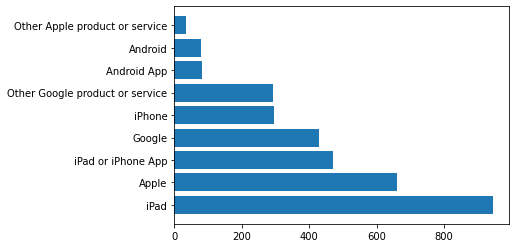

In [8]:
plt.barh(directed.value_counts().index, directed.value_counts().values);

In [9]:
directed.value_counts().sum()


3291

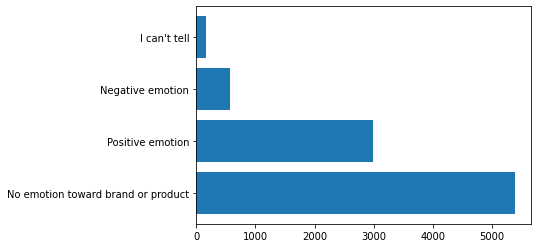

In [10]:
plt.barh(emotion.value_counts().index, emotion.value_counts().values);

In [11]:
emotion.value_counts()


No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### Clean Up & Tokenize

In [12]:
# Instantiating tokenizer
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")

# Create a list of stopwords in English
sw = stopwords.words('english')

In [13]:
sw.append('link')
sw.append('rt')
sw.append('sxsw')
sw.append('quot')

In [14]:
# instantiating Via_GoGo()
vg = VIA_GoGo()

# Creating a cleaned and shaped dataframe
clean_df = vg.clean_tokenizer(tweet_df, tokenizer, sw)
clean_df

,tweet_text,directed_at,emotion,emotion_num,brand,tweet_text_tokenized,joined_tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,-1,Apple,"[wesley83, 3g, iphone, hr, tweeting, rise_aust...",wesley83 3g iphone hr tweeting rise_austin dea...
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,1,Apple,"[jessedee, know, fludapp, awesome, ipad, iphon...",jessedee know fludapp awesome ipad iphone app ...
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,1,Apple,"[swonderlin, wait, ipad, also, sale]",swonderlin wait ipad also sale
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1,Apple,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,1,Google,"[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...
...,...,...,...,...,...,...,...
9084,"@mention yup, but i don't have a third app yet...",NaN,No emotion toward brand or product,0,Google,"[mention, yup, third, app, yet, android, sugge...",mention yup third app yet android suggestion c...
9085,ipad everywhere. #sxsw {link},iPad,Positive emotion,1,Apple,"[ipad, everywhere]",ipad everywhere
9086,"wave, buzz... rt @mention we interrupt your re...",NaN,No emotion toward brand or product,0,Google,"[wave, buzz, mention, interrupt, regularly, sc...",wave buzz mention interrupt regularly schedule...
9087,"google's zeiger, a physician never reported po...",NaN,No emotion toward brand or product,0,Google,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...


In [15]:
# Maing columns that shows either positive (1) or not positive (0) sentiment 
clean_df['emotion_pos_not'] = clean_df['emotion_num']
clean_df['emotion_pos_not'] = clean_df['emotion_pos_not'].replace({-1:0})

In [16]:
clean_df.emotion_pos_not.value_counts(normalize=True)

0    0.672351
1    0.327649
Name: emotion_pos_not, dtype: float64

In [17]:
# Creating new DataFrame that does not include neutral tweeets
binary_df = clean_df[clean_df.emotion_num != 0]

In [18]:
clean_df.emotion_num.value_counts(normalize=True)

 0    0.609638
 1    0.327649
-1    0.062713
Name: emotion_num, dtype: float64

In [19]:
binary_df.emotion_num.value_counts(normalize=True)

 1    0.839346
-1    0.160654
Name: emotion_num, dtype: float64

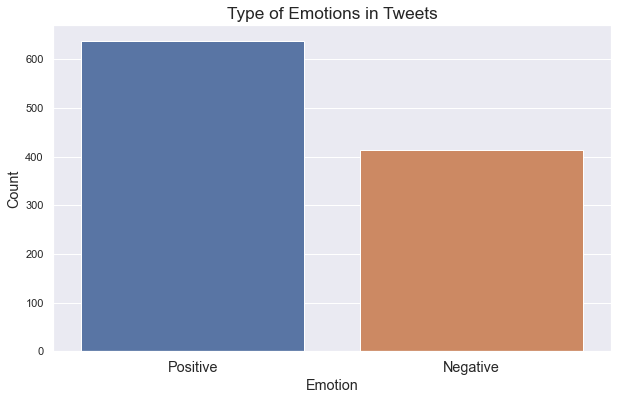

In [20]:
# visualize the counts of each emotion type
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=binary_df, 
    x="directed_at",
    order=binary_df.brand.value_counts().index)

ax.set_title('Type of Emotions in Tweets',fontsize='x-large')
ax.set_xlabel('Emotion',fontsize='large')
ax.set_ylabel('Count',fontsize='large')
plt.xticks(range(2), ['Positive','Negative'],fontweight='light', fontsize='large')

plt.show();

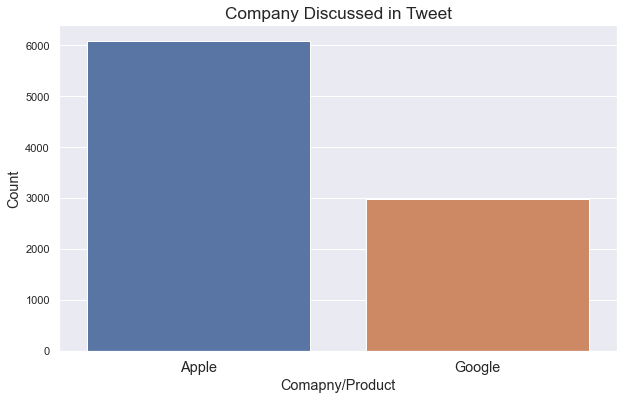

In [21]:
#visualize the counts of each company discussed in tweets
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(
   data=clean_df,
   x='brand', order=clean_df['brand'].value_counts().index)
ax.set_title('Company Discussed in Tweet', fontsize='x-large')
ax.set_xlabel('Comapny/Product',fontsize='large')
ax.set_xticklabels(ax.get_xticklabels(),fontweight='light', fontsize='large')
ax.set_ylabel('Count',fontsize='large')
plt.show();


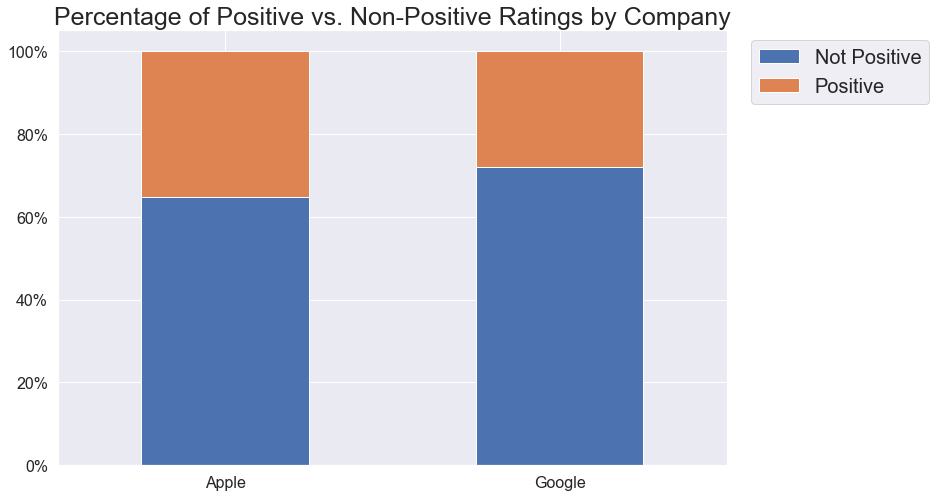

In [22]:
# visualize company/product mentioned by positive/non-positive emotion
import matplotlib.ticker as mtick
clean_df['pos_neg_neutral']=clean_df['emotion_num'] == 1
clean_df.groupby(['brand','pos_neg_neutral']).size().groupby(level=0).apply(
   lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, figsize=(12,8), legend='reverse')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor= (1.02, 1),prop = {'size' : 20},labels=('Not Positive', 'Positive'))
plt.xlabel('')
plt.xticks(fontsize=16,rotation=0,fontweight='light')
plt.yticks(fontsize=16)
plt.title('Percentage of Positive vs. Non-Positive Ratings by Company', size=25)
plt.show();

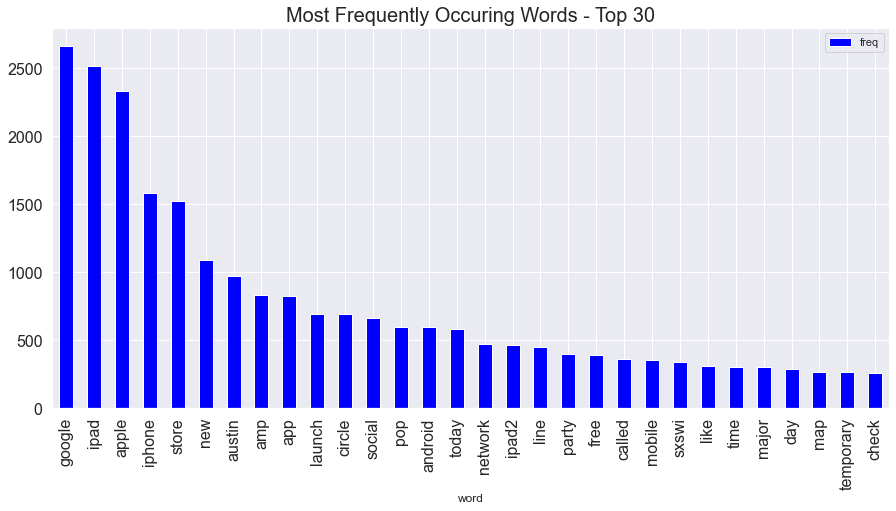

In [23]:
#graph frequency of top 30 words
from sklearn.feature_extraction import text
#add custom words to stop word list
stop_words = text.ENGLISH_STOP_WORDS.union(['sxsw','mention','link','rt'])
cv = CountVectorizer(stop_words = stop_words)
words = cv.fit_transform(clean_df.joined_tokens)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title('Most Frequently Occuring Words - Top 30', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

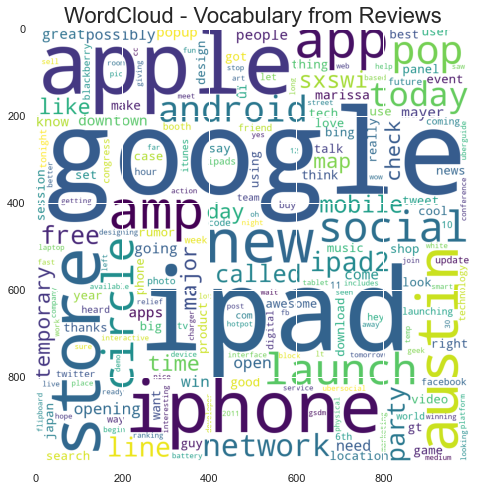

In [24]:
#create a word cloud of the tokenized words
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title('WordCloud - Vocabulary from Reviews', fontsize = 22);

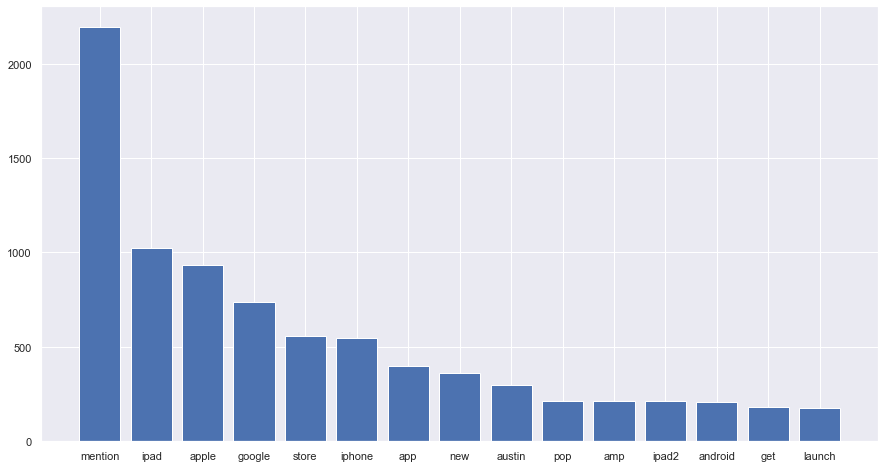

In [25]:
frequency_dist_positive = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == 1].explode())

top_ten = list(zip(*frequency_dist_positive.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

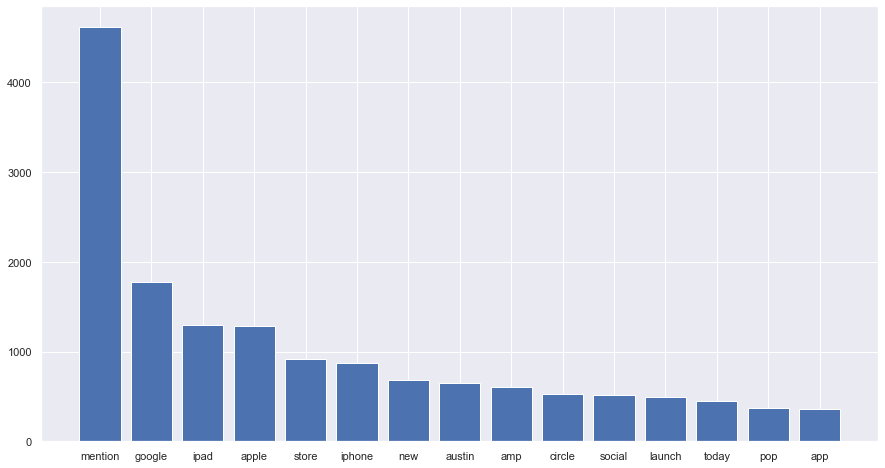

In [26]:
frequency_dist_neutral = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == 0].explode())

top_ten = list(zip(*frequency_dist_neutral.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

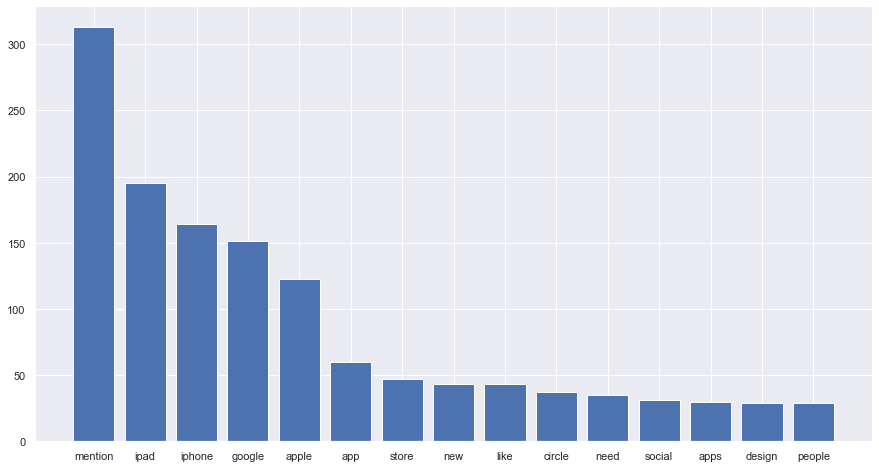

In [27]:
frequency_dist_negative = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == -1].explode())

top_ten = list(zip(*frequency_dist_negative.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

## Data Modeling <a class="anchor" id="Data_Modeling"></a>

### Binary Data Predictor <a class="anchor" id="Binary"></a>

#### Baseline  <a class="anchor" id="Binary_Baseline"></a>

In [28]:
# Using Linear Support Vector Machine
sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier()),
              ])

# Using Naive Bayes
naive = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

# Using Logistic Regression
lin_reg = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

# Using Random Forest
rfc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])

baseline_models = [sgd, naive, lin_reg, rfc]


In [29]:
metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

In [30]:
for model in baseline_models:   
    row = vg.run_model(model, metric_table, clean_df['joined_tokens'], clean_df['emotion_pos_not'], 'binary_baseline', join_str=False)
    metric_table = pd.concat([row])

metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline,0.7276,0.7532,binary_baseline
1,MultinomialNB()binary_baseline,0.7025,0.7259,binary_baseline
2,LogisticRegression()binary_baseline,0.7259,0.7431,binary_baseline
3,RandomForestClassifier()binary_baseline,0.7240,0.7523,binary_baseline


#### Tuned  <a class="anchor" id="Binary_Tuned"></a>

In [31]:
sgd_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])

naive_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

lin_reg_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=5)),
              ])

rfc_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100)),
              ])

baseline_tuned_models = [sgd_tuned, naive_tuned, lin_reg_tuned, rfc_tuned]

In [32]:
for model in baseline_tuned_models:   
    row = vg.run_model(model, metric_table, clean_df['joined_tokens'], clean_df['emotion_pos_not'], 'binary_tuned', join_str=False)
    metric_table = pd.concat([row])

metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline,0.7276,0.7532,binary_baseline
1,MultinomialNB()binary_baseline,0.7025,0.7259,binary_baseline
2,LogisticRegression()binary_baseline,0.7259,0.7431,binary_baseline
3,RandomForestClassifier()binary_baseline,0.7240,0.7523,binary_baseline
4,SGDClassifier()binary_tuned,0.7186,0.7571,binary_tuned
5,MultinomialNB()binary_tuned,0.7066,0.7308,binary_tuned
6,LogisticRegression()binary_tuned,0.7268,0.7422,binary_tuned
7,RandomForestClassifier()binary_tuned,0.7259,0.7527,binary_tuned


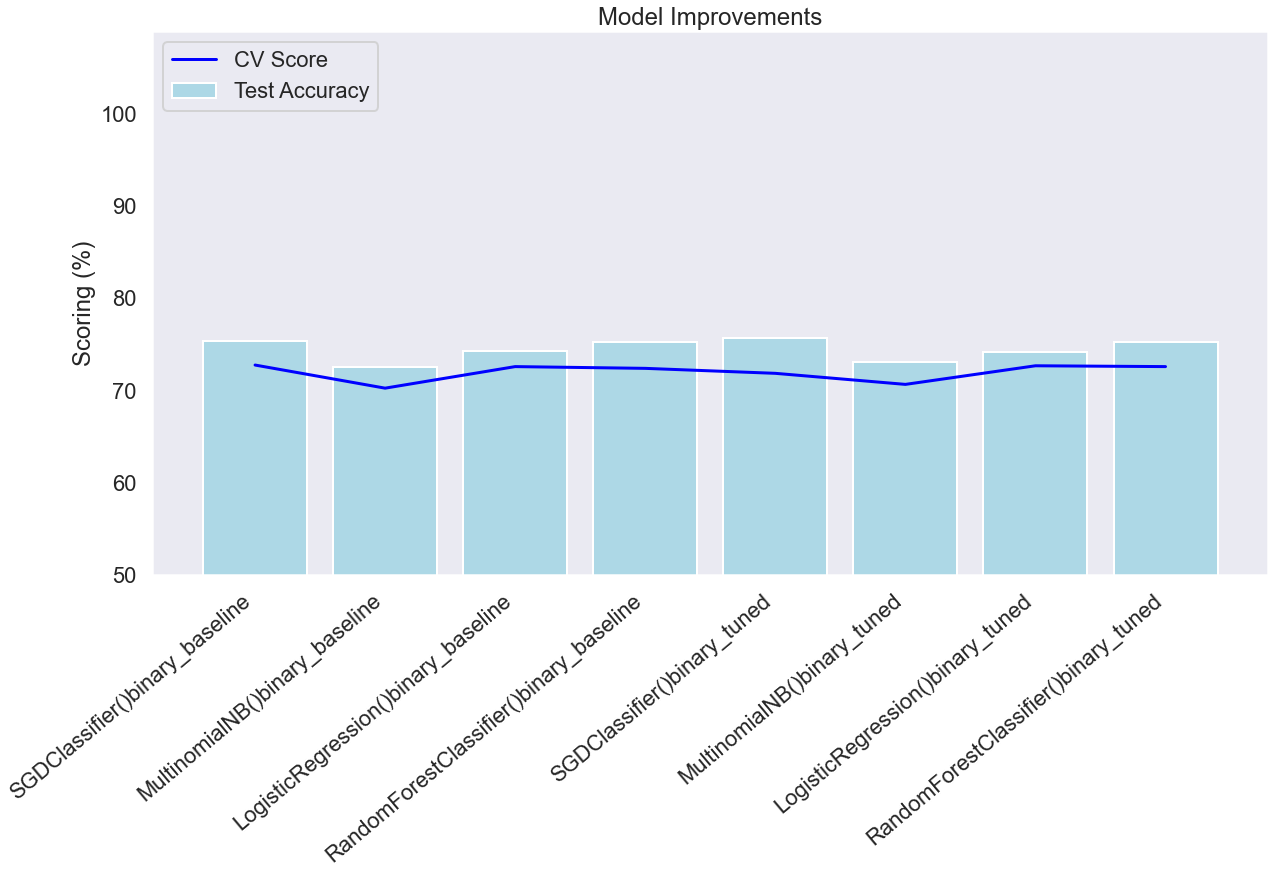

In [33]:
vg.plot_models(metric_table)

### Multiclass Data Predictor  <a class="anchor" id="Multiclass"></a>

#### Baseline  <a class="anchor" id="Multiclasss_Baseline"></a>

In [34]:
sgd_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])

naive_mc = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

lin_reg_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='newton-cg', n_jobs=5)),
              ])

rfc_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100, class_weight='balanced')),
              ])

multiclass_models = [sgd_mc, naive_mc, lin_reg_mc, rfc_mc]

In [35]:
metric_table_multi = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

In [36]:
for model in multiclass_models:   
    row = vg.run_model(model, metric_table_multi, clean_df['joined_tokens'], clean_df['emotion_num'], 'baseline_multiclass', join_str=False)
    metric_table_multi = pd.concat([row])

metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6736,0.7052,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6686,0.6828,baseline_multiclass


#### Tuned  <a class="anchor" id="Multiclass_Tuned"></a>

In [37]:
sgd_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])

naive_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

lin_reg_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='newton-cg', n_jobs=5)),
              ])

rfc_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100, class_weight='balanced')),
              ])

multiclass_models_tuned = [sgd_tuned_mc, naive_tuned_mc, lin_reg_tuned_mc, rfc_tuned_mc]

In [38]:
for model in multiclass_models_tuned:   
    row = vg.run_model(model, metric_table_multi, clean_df['joined_tokens'], clean_df['emotion_num'], 'tuned_multiclass', join_str=False)
    metric_table_multi = pd.concat([row])

metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6736,0.7052,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6686,0.6828,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.6734,0.7052,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.6492,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.6796,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.6712,0.6912,tuned_multiclass


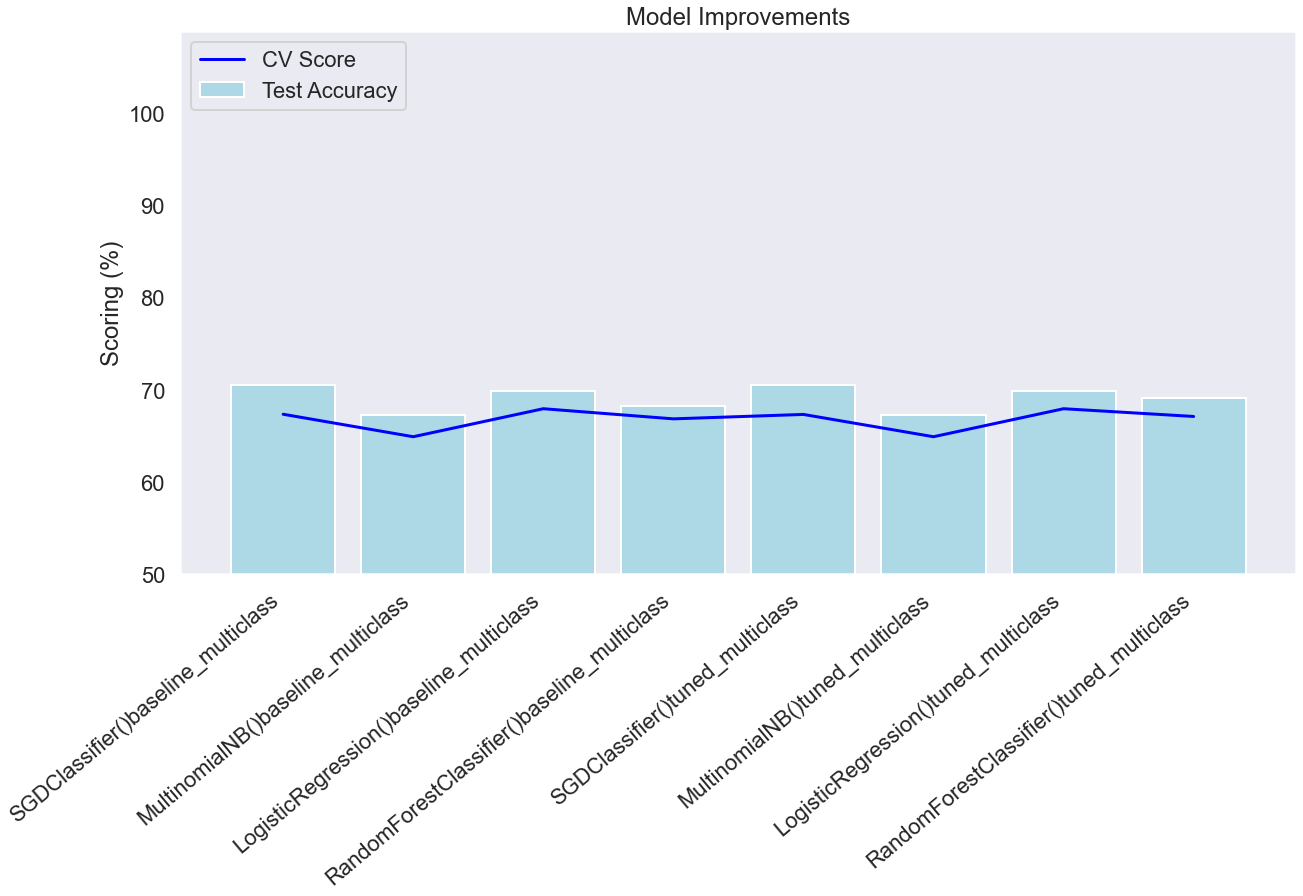

In [39]:
vg.plot_models(metric_table_multi)

### Adding Features <a class="anchor" id="Added_Features"></a>

In [40]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

clean_df['TextBlob_Polarity'] = clean_df['joined_tokens'].apply(getPolarity)

In [41]:
from afinn import Afinn
afinn = Afinn(language='en')

In [42]:
def getAffinscore(text):
    return afinn.score(text)
clean_df['Affin_score'] = clean_df['joined_tokens'].apply(getAffinscore)

In [43]:
sentiment_features = clean_df.loc[:,['TextBlob_Polarity', 'Affin_score']]

In [44]:
sentiment_features

,TextBlob_Polarity,Affin_score
0,-0.200000,-3.0
1,0.466667,7.0
2,0.000000,0.0
3,0.000000,2.0
4,0.800000,3.0
...,...,...
9084,0.000000,0.0
9085,0.000000,0.0
9086,0.000000,-1.0
9087,0.000000,0.0


In [45]:
clean_df['joined_tokens'] = clean_df['joined_tokens'].str.replace('\d+', '')

X = clean_df['joined_tokens']
countvec = CountVectorizer(min_df=5, ngram_range=(1,2), stop_words='english', strip_accents='unicode')


X_vec = countvec.fit_transform(X)

X_df = pd.DataFrame(X_vec.toarray(), columns=countvec.get_feature_names())
preprocess_features = sentiment_features.join(X_df, on=X_df.index)

In [46]:
preprocess_features.columns

Index(['TextBlob_Polarity', 'Affin_score', '______', 'a_', 'a_ edchat', 'aapl',
       'ab', 'abc', 'ability', 'able',
       ...
       'zazzle', 'zazzlesxsw', 'zazzlesxsw sxswi', 'zazzlsxsw',
       'zazzlsxsw uall', 'zlf', 'zomb', 'zombie', 'zomg', 'zomg mention'],
      dtype='object', length=3919)

In [47]:
clean_df['emotion_num'].shape

(9089,)

In [48]:
preprocess_features.shape

(9089, 3919)

In [49]:
sgd_feat = SGDClassifier()

rfc_feat = RandomForestClassifier(max_depth=100, n_estimators=100, class_weight='balanced')

feature_models = [sgd_feat, rfc_feat]

In [50]:
for model in feature_models:   
    row = vg.run_model(model, metric_table_multi, preprocess_features, clean_df['emotion_num'], 'features_multiclass', join_str=False, pipeline=False)
    metric_table_multi = pd.concat([row])

metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6736,0.7052,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6686,0.6828,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.6734,0.7052,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.6492,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.6796,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.6712,0.6912,tuned_multiclass
8,SGDClassifier()features_multiclass,0.6640,0.6872,features_multiclass
9,RandomForestClassifier()features_multiclass,0.6846,0.7026,features_multiclass


### Word2Vec <a class="anchor" id="Word2Vec"></a>

In [51]:
model_w2v = gensim.models.Word2Vec(
            sentences=clean_df.tweet_text_tokenized,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(clean_df.tweet_text_tokenized, total_examples=len(clean_df.tweet_text_tokenized), epochs=20)

(1393639, 1868820)

In [52]:
model_w2v.wv['iphone'].shape

(200,)

In [53]:
model_w2v.wv.most_similar(positive="iphone")

[('wew', 0.4892895519733429),
 ('desperate', 0.48023685812950134),
 ('pushed', 0.4712538719177246),
 ('handy', 0.4658361077308655),
 ('yayrt', 0.46450570225715637),
 ('merchant', 0.4623502194881439),
 ('vufinders', 0.4621181786060333),
 ('loaded', 0.45618313550949097),
 ('purse', 0.4504980742931366),
 ('powermatteam', 0.44796279072761536)]

In [54]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [55]:
clean_df.reset_index(inplace=True, drop=True)

In [56]:
wordvec_arrays = np.zeros((len(clean_df.tweet_text_tokenized), 200))

for i in range(len(clean_df.emotion_num)):
    wordvec_arrays[i,:] = word_vector(clean_df.tweet_text_tokenized[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape   

(9089, 200)

In [57]:
clean_df.emotion_num.shape

(9089,)

In [58]:
sgd_word2vec = SGDClassifier()
rfc_word2vec = RandomForestClassifier(class_weight='balanced')

word2vec_models = [sgd_word2vec, rfc_word2vec]

In [59]:
for model in word2vec_models:   
    row = vg.run_model(model, metric_table_multi, wordvec_df, clean_df['emotion_num'], 'word2vec', join_str=False, pipeline=False)
    metric_table_multi = pd.concat([row])
    
metric_table_multi


,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6736,0.7052,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6686,0.6828,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.6734,0.7052,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.6492,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.6796,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.6712,0.6912,tuned_multiclass
8,SGDClassifier()features_multiclass,0.6640,0.6872,features_multiclass
9,RandomForestClassifier()features_multiclass,0.6846,0.7026,features_multiclass


### Neural Network  <a class="anchor" id="Neural_Network"></a>

In [60]:
clean_df['emotion_num_nn'] = clean_df['emotion_num']

In [61]:
clean_df['emotion_num_nn'] = clean_df['emotion_num_nn'].replace(-1, 2)

In [62]:
X = clean_df['joined_tokens']
y =  clean_df['emotion_num_nn']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [64]:
tfidf = TfidfVectorizer(ngram_range=(1,2), )

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print('Shape of train features tensor:', X_train_vec.shape)
print('Shape of test features tensor:', X_test_vec.shape)

Shape of train features tensor: (6816, 38060)
Shape of test features tensor: (2273, 38060)


In [65]:
print('Shape of train label tensor:', y_train.shape)
print('Shape of test label tensor:', y_test.shape)

Shape of train label tensor: (6816,)
Shape of test label tensor: (2273,)


In [66]:
model = Sequential()
model.add(layers.Dense(300, input_dim=(38060), activation='relu' ))
model.add(Dropout(.5))
# model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

2022-02-18 11:20:01.460909: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-18 11:20:01.461513: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [67]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_vec, y_train, epochs=6, batch_size=1000, validation_split=.20, verbose=1)

Train on 5452 samples, validate on 1364 samples
Epoch 1/6
5452/5452 [==============================] - 5s 839us/sample - loss: 1.0771 - accuracy: 0.5442 - val_loss: 1.0339 - val_accuracy: 0.6334
Epoch 2/6
5452/5452 [==============================] - 4s 737us/sample - loss: 0.9922 - accuracy: 0.6172 - val_loss: 0.9606 - val_accuracy: 0.6342
Epoch 3/6
5452/5452 [==============================] - 3s 613us/sample - loss: 0.8961 - accuracy: 0.6267 - val_loss: 0.8897 - val_accuracy: 0.6371
Epoch 4/6
5452/5452 [==============================] - 3s 595us/sample - loss: 0.8005 - accuracy: 0.6469 - val_loss: 0.8313 - val_accuracy: 0.6400
Epoch 5/6
5452/5452 [==============================] - 4s 704us/sample - loss: 0.7130 - accuracy: 0.6898 - val_loss: 0.7874 - val_accuracy: 0.6481
Epoch 6/6
5452/5452 [==============================] - 3s 633us/sample - loss: 0.6340 - accuracy: 0.7592 - val_loss: 0.7557 - val_accuracy: 0.6554


In [68]:
results = model.evaluate(X_test_vec, y_test, batch_size=10)
print("test loss, test acc:", results)

2273/2273 [==============================] - 2s 756us/sample - loss: 0.7439 - accuracy: 0.6674
test loss, test acc: [0.743937536241512, 0.6673999]


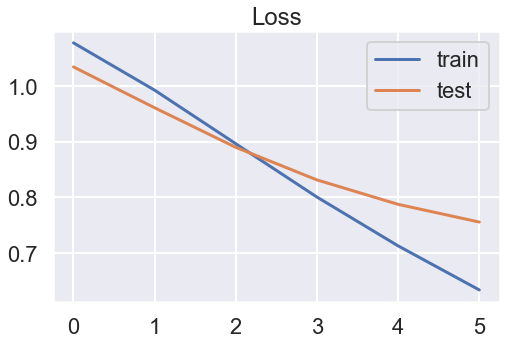

In [69]:
plt.figure(figsize=(8,5))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

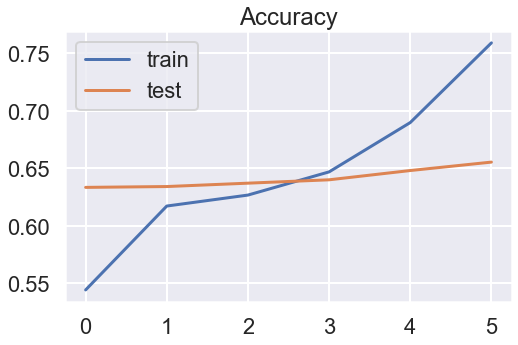

In [70]:
plt.figure(figsize=(8,5))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [71]:
NN_dict = {'Model': 'NeuralNetwork', 
            'CV Score': max(history.history['val_accuracy']),
            'Test Accuracy': results[1],
            'Type': 'multiclass_NN'}
NN_row = pd.DataFrame(NN_dict, index=[0])

metric_table_multi = pd.concat([metric_table_multi, NN_row], ignore_index=True)

### Recurrent Neural Network w/ LSTM <a class="anchor" id="RNN"></a>

In [72]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(clean_df['joined_tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8531 unique tokens.


In [73]:
X = tokenizer.texts_to_sequences(clean_df['joined_tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9089, 250)


In [74]:
Y = pd.get_dummies(clean_df['emotion_num']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9089, 3)


In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=5)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7271, 250) (7271, 3)
(1818, 250) (1818, 3)


In [76]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(4))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 1000

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', 
                                                                  patience=3, min_delta=0.0001)])

Train on 6543 samples, validate on 728 samples
Epoch 1/5


2022-02-18 11:20:28.687427: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_4736_5221' and '__inference___backward_standard_lstm_4736_5221_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_5373' both implement 'lstm_a90a7789-3009-4d5e-90eb-5a94bd32bd1b' but their signatures do not match.


6000/6543 [==========================>...] - ETA: 0s - loss: 1.0808 - accuracy: 0.5443

2022-02-18 11:20:37.089907: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_5706' and '__inference_standard_lstm_5595_specialized_for_sequential_1_lstm_StatefulPartitionedCall_at___inference_distributed_function_5973' both implement 'lstm_64bf0522-938a-431d-9763-44b333413aa3' but their signatures do not match.


6543/6543 [==============================] - 10s 2ms/sample - loss: 1.0787 - accuracy: 0.5482 - val_loss: 1.0524 - val_accuracy: 0.5989
Epoch 2/5
6543/6543 [==============================] - 7s 1ms/sample - loss: 1.0283 - accuracy: 0.6101 - val_loss: 1.0213 - val_accuracy: 0.5989
Epoch 3/5
6543/6543 [==============================] - 7s 1ms/sample - loss: 0.9923 - accuracy: 0.6098 - val_loss: 0.9979 - val_accuracy: 0.5989
Epoch 4/5
6543/6543 [==============================] - 7s 1ms/sample - loss: 0.9618 - accuracy: 0.6112 - val_loss: 0.9780 - val_accuracy: 0.6058
Epoch 5/5
6543/6543 [==============================] - 7s 1ms/sample - loss: 0.9326 - accuracy: 0.6147 - val_loss: 0.9604 - val_accuracy: 0.6085


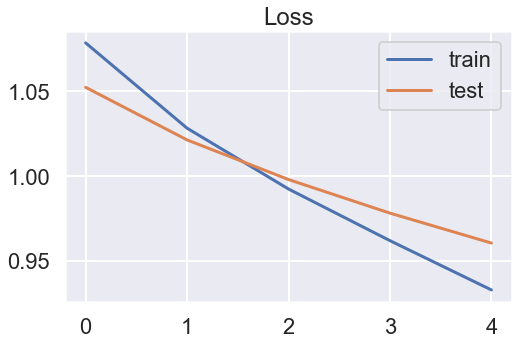

In [77]:
plt.figure(figsize=(8,5))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

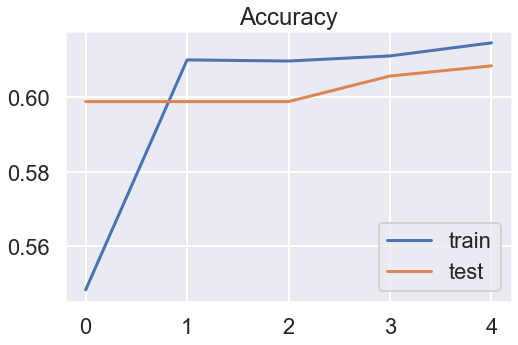

In [78]:
plt.figure(figsize=(8,5))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [83]:
RNN_dict = {'Model': 'RecurrentNeuralNetwork', 
            'CV Score': max(history.history['val_accuracy']),
            'Test Accuracy': 0,
            'Type': 'multiclass_NN'}
RNN_row = pd.DataFrame(RNN_dict, index=[0])

metric_table_multi = pd.concat([metric_table_multi, RNN_row], ignore_index=True)

In [84]:
metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.673600,0.7052,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.649200,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.679600,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.668600,0.6828,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.673400,0.7052,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.649200,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.679600,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.671200,0.6912,tuned_multiclass
8,SGDClassifier()features_multiclass,0.664000,0.6872,features_multiclass
9,RandomForestClassifier()features_multiclass,0.684600,0.7026,features_multiclass


### Final Model <a class="anchor" id="Final_Model"></a>

In [85]:
metric_table_multi.sort_values(by=['Test Accuracy'], ascending=False)

TypeError: '<' not supported between instances of 'str' and 'int'

In [86]:
X_train, X_test, y_train, y_test = train_test_split(clean_df['joined_tokens'], 
                                                    clean_df['emotion_num'], 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [87]:
final_preds = sgd_tuned_mc.predict(X_test)
final_trues = y_test

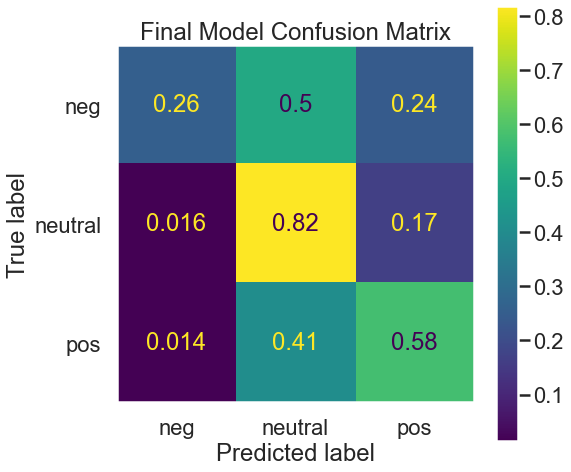

In [88]:
## FINAL MODEL
#sge_tuned_mc
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd_tuned_mc, X_test, y_test, ax=ax, display_labels=['neg', 'neutral', 'pos'], normalize='true')
plt.title('Final Model Confusion Matrix')
plt.grid(False)
plt.show();

In [89]:
pickle.dump(sgd_tuned_mc, open('final_clf.pkl', 'wb'))

## Results & Evaluation <a class="anchor" id="Results"></a>

Our baseline binary models classified tweets with an accuracy of 83 - 88%:

<img width="515" alt="Baseline Binary Models" src="https://user-images.githubusercontent.com/79488205/154533341-9aa712da-ded6-4b76-b809-75abea25f450.png">

Once we had this baseline, we continued to tune the models until we reached an accuracy score of 89% with our SGD Classifier model: 

<img width="504" alt="Tuned Binary Models" src="https://user-images.githubusercontent.com/79488205/154537919-16955719-995f-44bd-be1e-7ac72e7c70af.png">



## Online Application <a class="anchor" id="Online_App"></a>

We created an online application to demo the model's performance. The user can input a sample tweet and click the 'GoGo!' button, which will then return a sentiment score for the sample tweet of Positive, Negative, or Neutral.

![Online_App](images/online_app.jpg)

To demo the product, please visit this [link]().

## Recommendations <a class="anchor" id="Recommendations"></a>
Being competitive in the 21st century means utilizing 21st-century tools. ViaGogo’s Twitter Sentiment Analysis, built using natural language processing, offers Twitter an opportunity to give their brand users an advantage in the marketplace. This product enables businesses to capture public reactions about their company and products in a far more timely and authentic manner than focus groups or surveys. It collects and analyzes real-time reactions in order for businesses to make effective decisions.

The Twitter Sentiment Analysis adds value to businesses in 3 main ways:
-	Brand Perception – track what people are saying about a company/product in real-time within a mercurial social media environment;
-	Market Research – identify and explore the sentiments directed at one’s competitors in order to develop strategies based on their successes and struggles;
-	Customer Service – pinpoint which brands, locations, or services are thriving in customer satisfaction and which ones need the most urgent attention.

By adopting ViaGogo’s Twitter Sentiment Analysis and offering it as a service for corporate users, Twitter will increase its utility and make itself an indispensable part of the modern business landscape.


## Next Steps <a class="anchor" id="Next_Steps"></a>
ViaGogo in currently working on some new applications for its Twitter Sentiment Analysis. One product in development is the Positivity Rater. This tool gives users a positivity rating based on the analysis of the account’s past tweets. This can be useful to increase engagement among Twitters users. With so many people turned off by negative and harmful content, the Positivity Rater allows an individual to gauge how positive someone is when considering whether or not to follow them. We believe this will boost user activity and retain those who otherwise may stop using Twitter due to so much unwanted, pernicious content.

Another area ViaGoGo is actively working on is the creation of dashboards, which allow users to easily visualize sentiment analysis both in real-time and longitudinally. These dashboards will filter data on different dimensions, such as time frame, location, and product/service. It will also facilitate easy comparison of a given metric (for example, comparing the sentiments expressed towards 2 different branches or how sentiment about a product compares to this time last year).

Finally, ViaGoGo is already in production of a web app that allows users to write a tweet and see its sentiment rating before publishing it. This will ensure that the author strikes the appropriate tone with their tweet and can prevent thoughtless or poorly constructed tweets from entering the public domain. This feature will be valued by social media managers sitewide.

---
## Contact <a class="anchor" id="Contact"></a>
#### For more information
Please contact the contributors to this analysis: 
[Eddie Prado]() |
[Sally Heinzel]() |
[Valeria Viscarra Fossati](https://www.linkedin.com/in/valeria-vf/) |
[Weston Shuken](https://www.linkedin.com/in/westonshuken/)

[Return to top](#Top)